In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
import re
from string import punctuation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import confusion_matrix

nlp = spacy.load("en_core_web_lg")

c:\Users\muham\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\muham\anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
c:\Users\muham\anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
df = pd.read_csv("amazon_alexa.tsv", sep='\t')

In [3]:
df.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [4]:
df.shape

(3150, 5)

In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3150 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


We have 5 variables to consider on 3150 reviews :

1. The rating gave by the client on the reviews, which is an integer number from 1 to 5.
2. The date of the review , an object which will further be transformed into datetime.
3. The variation on the product which is a chrachteristic differing the models of the product.
4. Verified_reviews this is the full text of the review.
5. Feedback of each review which is positive or negative.


In [6]:
pos_reviews = df['feedback'].value_counts()[1]
neg_reviews = df['feedback'].value_counts()[0]

print(f"The number of positive reviews is {pos_reviews} and negative reviews is {neg_reviews} \n")

for i in range(1, 6):
    print(df["rating"].value_counts()[i], "ratings =", i)

The number of positive reviews is 2893 and negative reviews is 257 

161 ratings = 1
96 ratings = 2
152 ratings = 3
455 ratings = 4
2286 ratings = 5


In [7]:
df.describe()

,rating,feedback
count,3150.000000,3150.000000
mean,4.463175,0.918413
std,1.068506,0.273778
min,1.000000,0.000000
25%,4.000000,1.000000
50%,5.000000,1.000000
75%,5.000000,1.000000
max,5.000000,1.000000


In [8]:
df[df["feedback"] == 1].describe()

,rating,feedback
count,2893.000000,2893.0
mean,4.737643,1.0
std,0.546544,0.0
min,3.000000,1.0
25%,5.000000,1.0
50%,5.000000,1.0
75%,5.000000,1.0
max,5.000000,1.0


In [9]:
df[df["feedback"] == 0].describe()

,rating,feedback
count,257.000000,257.0
mean,1.373541,0.0
std,0.484688,0.0
min,1.000000,0.0
25%,1.000000,0.0
50%,1.000000,0.0
75%,2.000000,0.0
max,2.000000,0.0


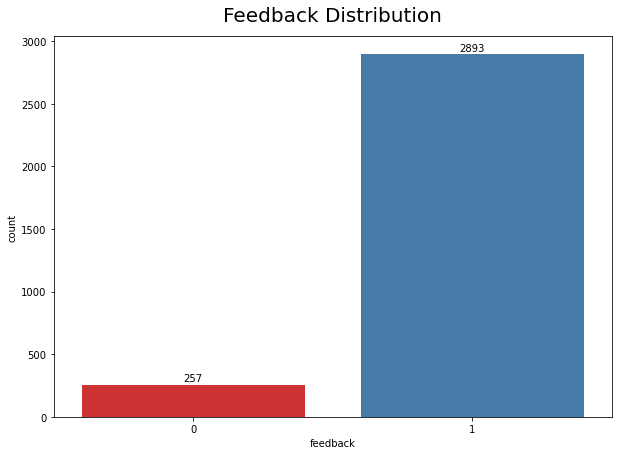

In [10]:
fig, ax1 = plt.subplots(figsize=(10, 7))
graph = sns.countplot(ax=ax1, x="feedback", data=df, palette="Set1")
graph.set_title("Feedback Distribution", fontsize=20, pad=15)
graph.set_xticklabels(graph.get_xticklabels(), rotation=0)
values = df['feedback'].value_counts(ascending=True).values
for i, p in enumerate(graph.patches):
    graph.text(p.get_x()+p.get_width()/2,
               p.get_height() + 30, values[i], ha="center")


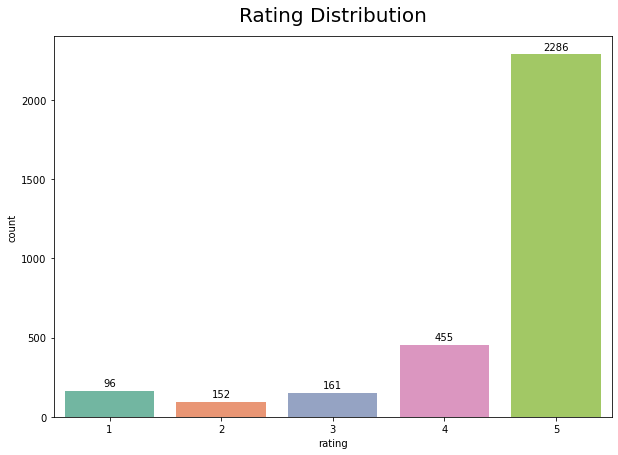

In [11]:
fig, ax1 = plt.subplots(figsize=(10, 7))
graph = sns.countplot(ax=ax1, x="rating", data=df, palette="Set2")
graph.set_title("Rating Distribution", fontsize=20, pad=15)
graph.set_xticklabels(graph.get_xticklabels(), rotation=0)
values = df['rating'].value_counts(ascending=True).values
for i, p in enumerate(graph.patches):
    graph.text(p.get_x()+p.get_width()/2,
               p.get_height() + 30, values[i], ha="center")

From this initial analysis we can gather that:

- Rating from 3 to 5 are classified as positive reviews and from 1 to 2 as negative reviews.
- Amazon Alexa has a good reviews general.
- The majority of reviews have 5 raring.


In [12]:
df["length"] = df['verified_reviews'].apply(len)
df.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,195
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,172
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


c:\Users\muham\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


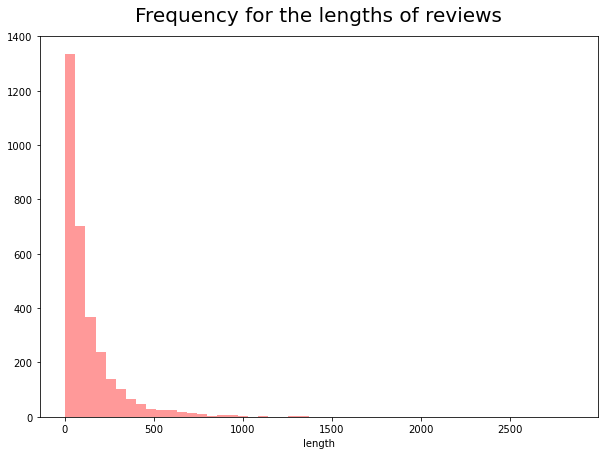

In [13]:
fig, ax = plt.subplots(figsize=(10, 7))
tips = sns.load_dataset('tips')
ax.set_title("Frequency for the lengths of reviews", fontsize=20, pad=15)
sns.distplot(a=df["length"], hist=True, kde=False, rug=False, color='red')
plt.show()


In [14]:
df[df["feedback"] == 1].describe()

,rating,feedback,length
count,2893.000000,2893.0,2893.000000
mean,4.737643,1.0,124.659177
std,0.546544,0.0,174.624491
min,3.000000,1.0,1.000000
25%,5.000000,1.0,29.000000
50%,5.000000,1.0,69.000000
75%,5.000000,1.0,154.000000
max,5.000000,1.0,2851.000000


In [15]:
df[df["feedback"] == 0].describe()

,rating,feedback,length
count,257.000000,257.0,257.000000
mean,1.373541,0.0,215.241245
std,0.484688,0.0,236.325955
min,1.000000,0.0,1.000000
25%,1.000000,0.0,53.000000
50%,1.000000,0.0,137.000000
75%,2.000000,0.0,289.000000
max,2.000000,0.0,1686.000000


We can conclude that:

- Most of the reviews have around 300 characters.
- The shortest review has 1 character and the longest review has 2851 characters.
- The length of the review differs, on average, if the review is positive or negative.
- Positive reviews are, on average, 124 characters long and negative reviews are, on average, 215 characters long.
- We may conclude that, on average, people who are unhappy with the product tend to write longer reviews.


In [16]:
df["variation"].unique()

array(['Charcoal Fabric ', 'Walnut Finish ', 'Heather Gray Fabric ',
       'Sandstone Fabric ', 'Oak Finish ', 'Black', 'White',
       'Black  Spot', 'White  Spot', 'Black  Show', 'White  Show',
       'Black  Plus', 'White  Plus', 'Configuration: Fire TV Stick',
       'Black  Dot', 'White  Dot'], dtype=object)

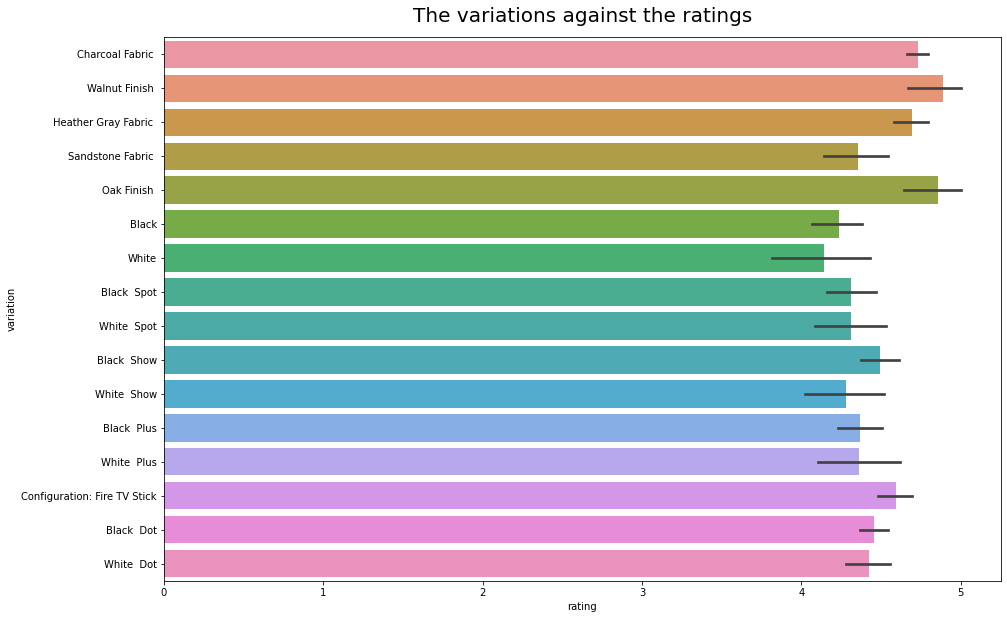

In [17]:
fig, ax1 = plt.subplots(figsize=(15, 10))
graph = sns.barplot(ax=ax1, y="variation", x="rating", data=df, orient="h")
graph.set_title("The variations against the ratings", fontsize=20, pad=15)
plt.show()

In [18]:
total_characters = sum(df["length"])
positive_characters = sum(df[df["feedback"] == 1].length)
negative_characters = sum(df[df["feedback"] == 0].length)

In [19]:
print(f"Total number of characters is {total_characters}")
print(f"{positive_characters} characters are in the positive reviews ({round(positive_characters/total_characters,2) * 100}%)")
print(f"{negative_characters} characters are in the negative reviews ({round(negative_characters/total_characters,2) * 100}%)")

Total number of characters is 415956
360639 characters are in the positive reviews (87.0%)
55317 characters are in the negative reviews (13.0%)


In [20]:
def clean_text (sentence):
    sent = sentence.strip().lower()
    sent = " ".join(re.findall("[a-zA-Z]+", sent )) 
    tokens = nlp(sent)
    tokens = [w.lemma_ for w in tokens if w.lemma_ not in punctuation  and w.is_stop == False  ]
    text = " ".join(tokens) 
    return text

In [21]:
df.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,195
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,172
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [22]:
df["verified_reviews"] = df["verified_reviews"].apply(clean_text)

In [23]:
df.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,love echo,1,13
1,5,31-Jul-18,Charcoal Fabric,love,1,9
2,4,31-Jul-18,Walnut Finish,play game answer question correctly alexa say ...,1,195
3,5,31-Jul-18,Charcoal Fabric,lot fun thing yr old learn dinosaur control li...,1,172
4,5,31-Jul-18,Charcoal Fabric,music,1,5


In [24]:
X = df["verified_reviews"]
y = df["feedback"]

In [26]:
tfidfconverter = TfidfVectorizer(max_features=1500, min_df=5, max_df=0.7)
X = tfidfconverter.fit_transform(X).toarray()

In [27]:
X.shape

(3150, 854)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)
print('y_train shape is ' , y_train.shape)
print('y_test shape is ' , y_test.shape)

X_train shape is  (2520, 854)
X_test shape is  (630, 854)
y_train shape is  (2520,)
y_test shape is  (630,)


In [29]:
LogisticRegressionModel = LogisticRegression(penalty='l2',solver='sag',C=1.0,random_state=33)
LogisticRegressionModel.fit(X_train, y_train)

print('LogisticRegressionModel Train Score is : ' , LogisticRegressionModel.score(X_train, y_train))
print('LogisticRegressionModel Test Score is : ' , LogisticRegressionModel.score(X_test, y_test))
print('LogisticRegressionModel Classes are : ' , LogisticRegressionModel.classes_)
print('LogisticRegressionModel No. of iteratios is : ' , LogisticRegressionModel.n_iter_)

LogisticRegressionModel Train Score is :  0.925
LogisticRegressionModel Test Score is :  0.9158730158730158
LogisticRegressionModel Classes are :  [0 1]
LogisticRegressionModel No. of iteratios is :  [24]


In [30]:
y_pred = LogisticRegressionModel.predict(X_test)
y_pred_prob = LogisticRegressionModel.predict_proba(X_test)
print('Predicted Value for LogisticRegressionModel is : ' , y_pred[:10])
print('Prediction Probabilities Value for LogisticRegressionModel is : ' , y_pred_prob[:10])

Predicted Value for LogisticRegressionModel is :  [1 1 1 1 1 1 1 1 1 1]
Prediction Probabilities Value for LogisticRegressionModel is :  [[0.04302611 0.95697389]
 [0.11713986 0.88286014]
 [0.08776128 0.91223872]
 [0.36855102 0.63144898]
 [0.03182706 0.96817294]
 [0.1252728  0.8747272 ]
 [0.04891052 0.95108948]
 [0.02381262 0.97618738]
 [0.08731131 0.91268869]
 [0.36887242 0.63112758]]


In [31]:
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.02      0.04        54
           1       0.92      1.00      0.96       576

    accuracy                           0.92       630
   macro avg       0.96      0.51      0.50       630
weighted avg       0.92      0.92      0.88       630

0.9158730158730158


In [32]:
CM = confusion_matrix(y_test, y_pred)
print('Confusion Matrix is : \n', CM)

Confusion Matrix is : 
 [[  1  53]
 [  0 576]]


In [33]:
RandomForestClassifierModel = RandomForestClassifier(criterion = 'gini',n_estimators=100,max_depth=2,random_state=33) #criterion can be also : entropy 
RandomForestClassifierModel.fit(X_train, y_train)

print('RandomForestClassifierModel Train Score is : ' , RandomForestClassifierModel.score(X_train, y_train))
print('RandomForestClassifierModel Test Score is : ' , RandomForestClassifierModel.score(X_test, y_test))
# print('RandomForestClassifierModel features importances are : ' , RandomForestClassifierModel.feature_importances_)

RandomForestClassifierModel Train Score is :  0.9194444444444444
RandomForestClassifierModel Test Score is :  0.9142857142857143


In [34]:
y_pred = RandomForestClassifierModel.predict(X_test)
y_pred_prob = RandomForestClassifierModel.predict_proba(X_test)
print('Predicted Value for RandomForestClassifierModel is : ' , y_pred[:10])
print('Prediction Probabilities Value for RandomForestClassifierModel is : \n' , y_pred_prob[:10])

Predicted Value for RandomForestClassifierModel is :  [1 1 1 1 1 1 1 1 1 1]
Prediction Probabilities Value for RandomForestClassifierModel is : 
 [[0.07646495 0.92353505]
 [0.07646495 0.92353505]
 [0.07646495 0.92353505]
 [0.1293164  0.8706836 ]
 [0.07646495 0.92353505]
 [0.07646495 0.92353505]
 [0.07646495 0.92353505]
 [0.07127449 0.92872551]
 [0.07684241 0.92315759]
 [0.13250126 0.86749874]]


In [35]:
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        54
           1       0.91      1.00      0.96       576

    accuracy                           0.91       630
   macro avg       0.46      0.50      0.48       630
weighted avg       0.84      0.91      0.87       630

0.9142857142857143


C:\Users\muham\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
CM = confusion_matrix(y_test, y_pred)
print('Confusion Matrix is : \n', CM)

Confusion Matrix is : 
 [[  0  54]
 [  0 576]]


In [37]:
MultinomialNBModel = MultinomialNB(alpha=1.0)
MultinomialNBModel.fit(X_train, y_train)

print('MultinomialNBModel Train Score is : ' , MultinomialNBModel.score(X_train, y_train))
print('MultinomialNBModel Test Score is : ' , MultinomialNBModel.score(X_test, y_test))

MultinomialNBModel Train Score is :  0.9230158730158731
MultinomialNBModel Test Score is :  0.9206349206349206


In [38]:
y_pred = MultinomialNBModel.predict(X_test)
y_pred_prob = MultinomialNBModel.predict_proba(X_test)
print('Predicted Value for MultinomialNBModel is : ' , y_pred[:10])
print('Prediction Probabilities Value for MultinomialNBModel is : ' , y_pred_prob[:10])

Predicted Value for MultinomialNBModel is :  [1 1 1 1 1 1 1 1 1 1]
Prediction Probabilities Value for MultinomialNBModel is :  [[0.02015623 0.97984377]
 [0.08055556 0.91944444]
 [0.01596822 0.98403178]
 [0.32040021 0.67959979]
 [0.01641652 0.98358348]
 [0.0936622  0.9063378 ]
 [0.04951476 0.95048524]
 [0.01496368 0.98503632]
 [0.03665147 0.96334853]
 [0.46321057 0.53678943]]


In [39]:
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.07      0.14        54
           1       0.92      1.00      0.96       576

    accuracy                           0.92       630
   macro avg       0.96      0.54      0.55       630
weighted avg       0.93      0.92      0.89       630

0.9206349206349206


In [40]:
CM = confusion_matrix(y_test, y_pred)
print('Confusion Matrix is : \n', CM)

Confusion Matrix is : 
 [[  4  50]
 [  0 576]]
